# Example: gridworld

An agent is tasked with reaching a target in a gridworld with potentially dangerous areas

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

from best.models.pomdp import POMDP, POMDPNetwork
from best.solvers.valiter import solve_ltl_cosafe
from best.logic.translate import formula_to_logic

### Define two label MDPs

In [2]:
T0 = np.eye(3)
T1 = np.array([[0,0.5,0.5], [0,1,0], [0,0,1]])

output_fcn = lambda n: {0: 'init', 1: 'safe', 2: 'únsafe'}[n]
    
map1 = POMDP([T0, T1], input_names=['meas1'], output_trans=output_fcn, state_name='label1')
map2 = POMDP([T0, T1], input_names=['meas2'], output_trans=output_fcn, state_name='label2')

print(map1)
print(map2)

MDP: (2,) inputs ('meas1',) --> 3 states label1 --> 3 outputs label1
MDP: (2,) inputs ('meas2',) --> 3 states label2 --> 3 outputs label2


### Define gridworld system MDP

In [3]:
# gridworld mdp
l_x = 4  # x length
l_y = 2  # y length

T_start = [np.ravel_multi_index( (i,j), (l_x, l_y)) for i in range(l_x) for j in range(l_y)]

Tn_end = [np.ravel_multi_index( (i, max(0, j-1)), (l_x, l_y))     for i in range(l_x) for j in range(l_y)]
Ts_end = [np.ravel_multi_index( (i, min(l_y-1, j+1)), (l_x, l_y)) for i in range(l_x) for j in range(l_y)]
Te_end = [np.ravel_multi_index( (min(l_x-1, i+1), j), (l_x, l_y)) for i in range(l_x) for j in range(l_y)]
Tw_end = [np.ravel_multi_index( (max(0, i-1), j), (l_x, l_y))     for i in range(l_x) for j in range(l_y)]

Tn = sp.coo_matrix((np.ones(l_x*l_y), (T_start, Tn_end)), shape=(l_x*l_y, l_x*l_y))
Ts = sp.coo_matrix((np.ones(l_x*l_y), (T_start, Ts_end)), shape=(l_x*l_y, l_x*l_y))
Te = sp.coo_matrix((np.ones(l_x*l_y), (T_start, Te_end)), shape=(l_x*l_y, l_x*l_y))
Tw = sp.coo_matrix((np.ones(l_x*l_y), (T_start, Tw_end)), shape=(l_x*l_y, l_x*l_y))

syst_mdp = POMDP([Tn, Ts, Te, Tw], input_names=['dir'], state_name='s')

print(syst_mdp)

MDP: (4,) inputs ('dir',) --> 8 states s --> 8 outputs s


### Connect system and labels

MDP network: (4,) inputs ('dir',), (8, 3, 3) states ('s', 'label1', 'label2'), (8, 3, 3) outputs ('s', 'label1', 'label2')


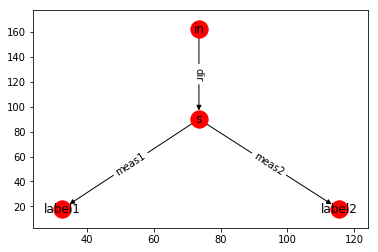

In [4]:
# define mappings s -> meas1 and s -> meas2
network = POMDPNetwork([syst_mdp, map1, map2])
network.add_connection(['s'], 'meas1', lambda s: set([s==2]) )
network.add_connection(['s'], 'meas2', lambda s: set([s==3]) )

network.plot()
print(network)

### Solve LTL problem on product system

In [5]:
# define formula and APs
formula = 'safe U target'

def safe_fcn(s, lab1, lab2):
    return set([(s != 4 or lab1 == 'safe') and (s != 5 or lab2 == 'safe')])

def target_fcn(s):
    return set([s==6])

predicates = {'safe': (['s', 'label1', 'label2'], safe_fcn),
              'target': (['s'], target_fcn)} 

# solve synthesis problem
pol = solve_ltl_cosafe(network, formula, predicates, delta=0.0001)

finished after 0.02s and 5 iterations


### Simple simulation (p=0.75 of success)

In [6]:
np.random.seed(6)   # long path
# np.random.seed(0) # fail

state = [0, 0, 0]
p = 1

pol.reset()

while not pol.finished() and p > 0:
    print ("current state", state)

    # report atomic propositions
    aps = set()
    if safe_fcn(*state):
        aps |= {'safe'}
    if state[0] == 6:
        aps |= {'target'}
    pol.report_aps(aps)
    
    # get input
    u, p = pol(state)
    print ("input", u, "probability of sat", p)

    # simulate
    state, output = network.evolve(state, u)
    print ("moved to", state, "and observed", output, '\n')    

current state [0, 0, 0]
input (2,) probability of sat 0.749675
moved to [2, 2, 0] and observed (2, 'únsafe', 'init') 

current state [2, 2, 0]
input (1,) probability of sat 0.49975
moved to [3, 2, 1] and observed (3, 'únsafe', 'safe') 

current state [3, 2, 1]
input (2,) probability of sat 0.99969995
moved to [5, 2, 1] and observed (5, 'únsafe', 'safe') 

current state [5, 2, 1]
input (2,) probability of sat 0.99979997
moved to [7, 2, 1] and observed (7, 'únsafe', 'safe') 

current state [7, 2, 1]
input (0,) probability of sat 0.9999
moved to [6, 2, 1] and observed (6, 'únsafe', 'safe') 

current state [6, 2, 1]
input (0,) probability of sat 1.0
moved to [6, 2, 1] and observed (6, 'únsafe', 'safe') 

